# Import Data

In [1]:
#import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
raw_csv_data = pd.read_csv("Week11_in10mins.csv")      #import the csv
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp.customer =df_comp.customer.fillna(value = df_comp.customer.mean())

In [3]:
from statsmodels.tsa.stattools import adfuller
# from numpy import log
result = adfuller(df_comp.customer.fillna(value = df_comp.customer.mean()))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.082224
p-value: 0.000000


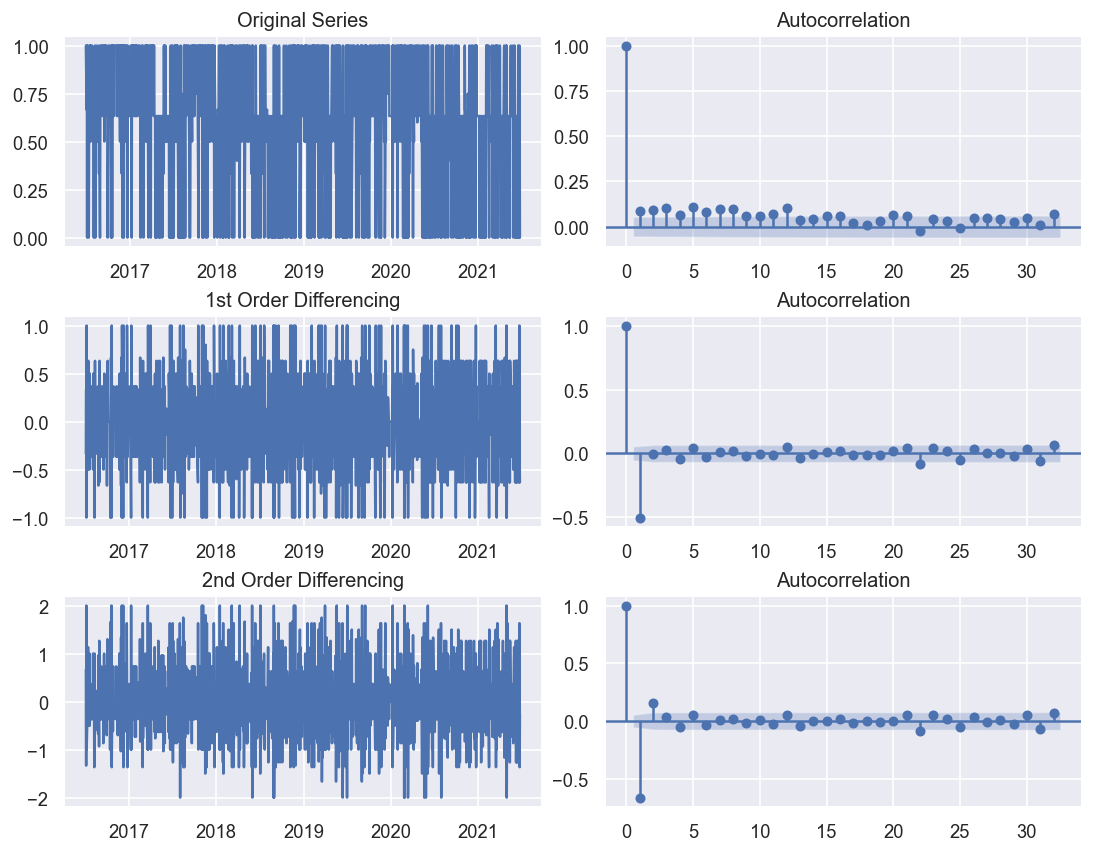

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=False, constrained_layout=True)
axes[0, 0].plot(df_comp.customer); axes[0, 0].set_title('Original Series')
plot_acf(df_comp.customer, ax=axes[0, 1])


# 1st Differencing
axes[1, 0].plot(df_comp.customer.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_comp.customer.diff().fillna(value = df_comp.customer.mean()), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_comp.customer.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_comp.customer.diff().diff().fillna(value = df_comp.customer.mean()), ax=axes[2, 1])

plt.show()

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv("Week11_in10mins.csv")
y = df.customer

## Adf Test
ndiffs(y, test='adf')  # 2

# KPSS test
ndiffs(y, test='kpss')  # 0

# PP test:
ndiffs(y, test='pp')  # 2

0

# Find the order of the AR term (p)

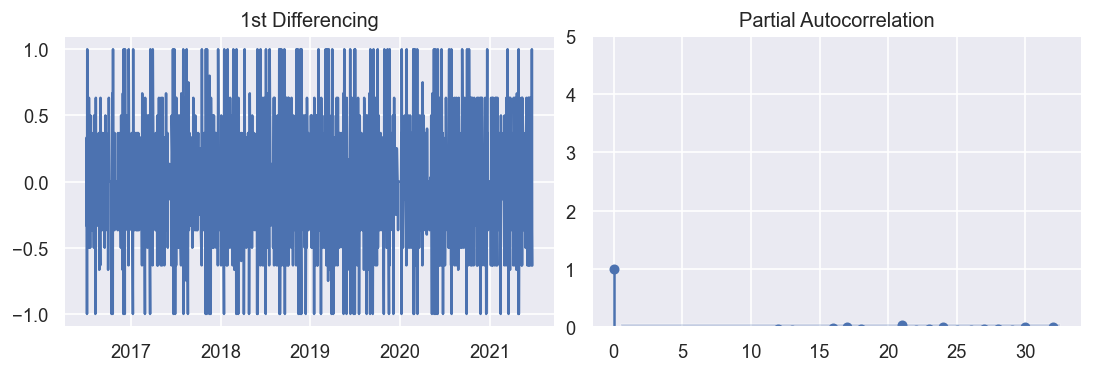

In [7]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False, constrained_layout=True)
axes[0].plot(df_comp.customer.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_comp.customer.diff().fillna(value = df_comp.customer.mean()), ax=axes[1])

plt.show()

# Find the order of the MA term (q)

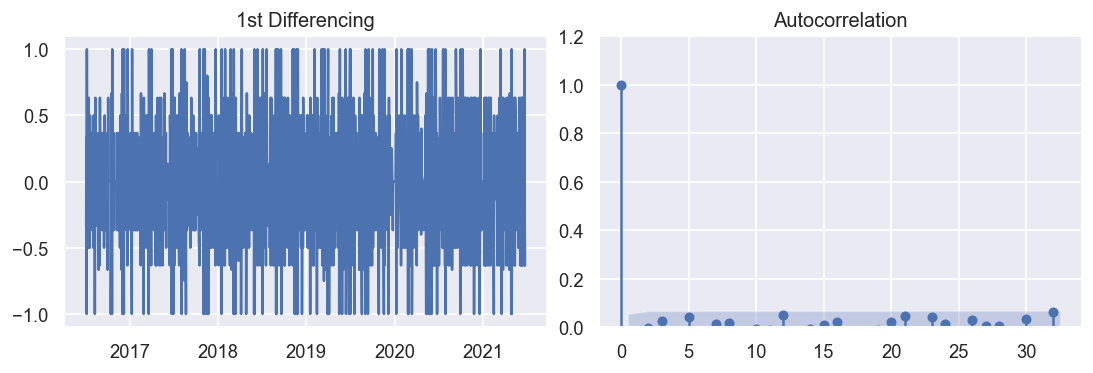

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False, constrained_layout=True)
axes[0].plot(df_comp.customer.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_comp.customer.diff().fillna(value = df_comp.customer.mean()), ax=axes[1])

plt.show()

# Build the ARIMA Model

In [9]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df_comp.customer, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.customer   No. Observations:                 1299
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -445.481
Method:                       css-mle   S.D. of innovations              0.341
Date:                Mon, 08 Nov 2021   AIC                            898.962
Time:                        16:35:45   BIC                            919.639
Sample:                    07-04-2016   HQIC                           906.721
                         - 06-24-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0002      0.000     -0.439      0.660      -0.001       0.001
ar.L1.D.customer     0.0155      0.030      0.514      0.607      -0.044       0.075
ma.L1.D.customer    -0.9627 

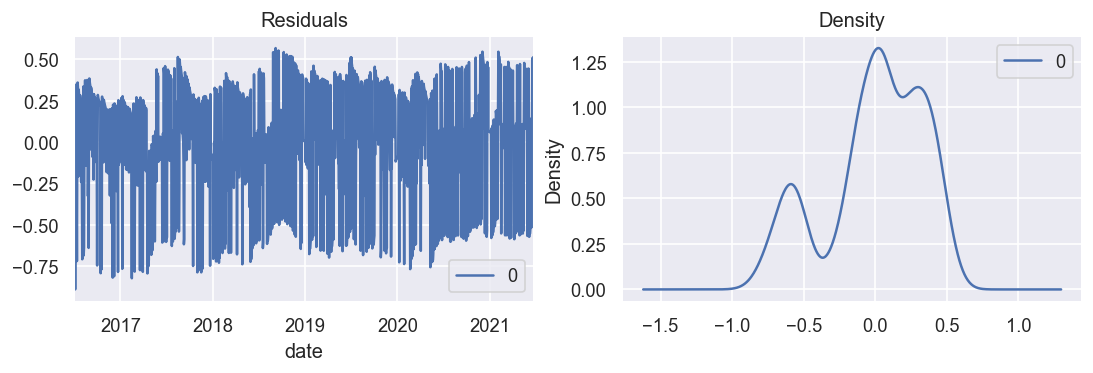

In [10]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, constrained_layout=True)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

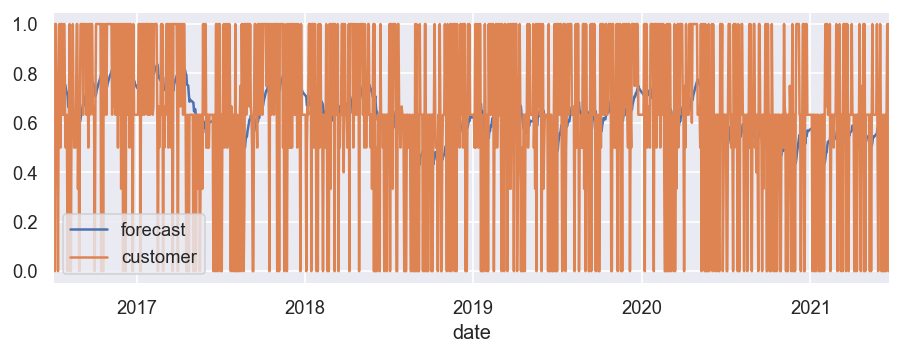

In [11]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

# Find the optimal ARIMA model using Out-of-Time Cross validation

In [12]:
size = int(len(df_comp)*0.8)
train, test = df_comp.iloc[:size], df_comp.iloc[size:]


In [13]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df_comp.customer[:size]#'2021-05-31'
test = df_comp.customer[size:]

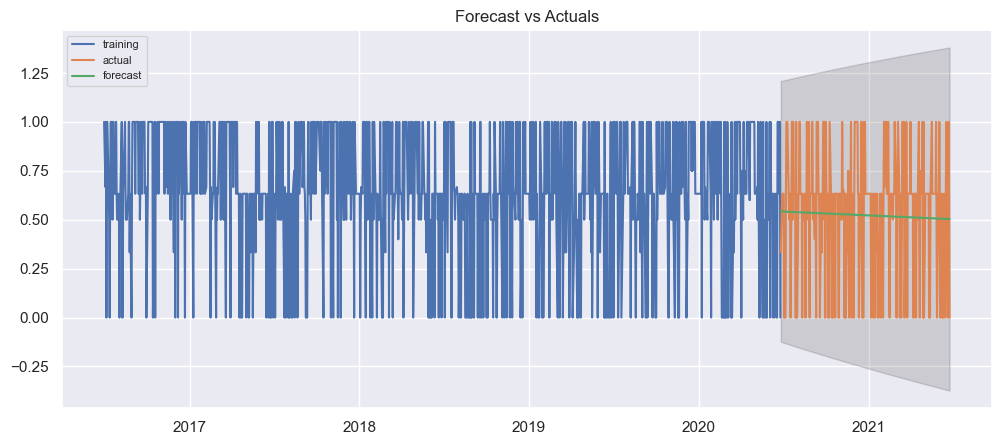

In [14]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(260, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:             D.customer   No. Observations:                 1039
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -349.991
Method:                       css-mle   S.D. of innovations              0.338
Date:                Mon, 08 Nov 2021   AIC                            713.983
Time:                        16:35:50   BIC                            748.605
Sample:                    07-04-2016   HQIC                           727.117
                         - 06-25-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0001      0.001     -0.258      0.796      -0.001       0.001
ar.L1.D.customer    -1.8132      0.001  -1357.894      0.000      -1.816      -1.811
ar.L2.D.customer    -0.9995 

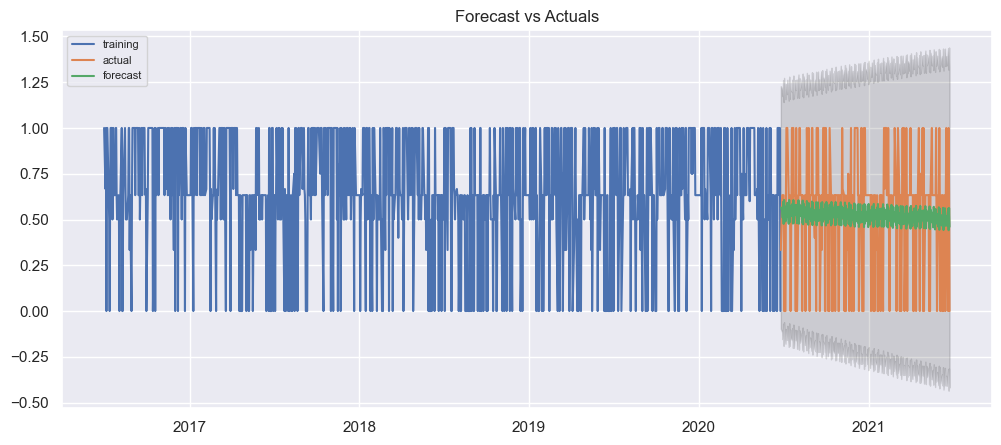

In [15]:
# Build Model
model = ARIMA(train, order=(2, 1, 3))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(260, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy Metrics for Time Series Forecast

In [16]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': inf,
 'me': -0.012826677269247537,
 'mae': 0.2677826174316075,
 'mpe': inf,
 'rmse': 0.33491572090653704,
 'acf1': 0.042780928393245696,
 'corr': 0.12891267899467115,
 'minmax': 0.41855204937009227}

# Auto Arima Forecasting in Python

In [17]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(df.customer, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=934.849, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2023.409, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1325.441, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1672.488, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=934.703, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1175.336, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=936.592, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=938.848, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=934.751, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1089.353, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=938.608, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=925.591, Time=0.79 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=923.741, Time=0.57 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=965.853, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=

# Interpreting the residual plots in ARIMA model

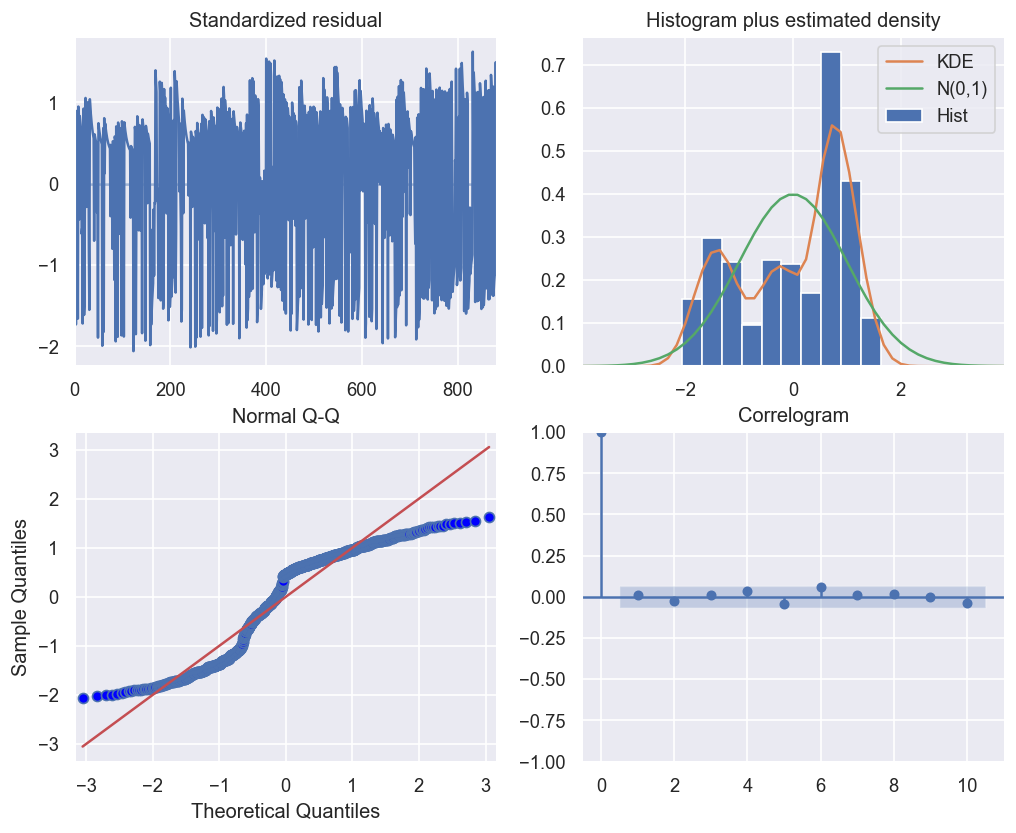

In [18]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

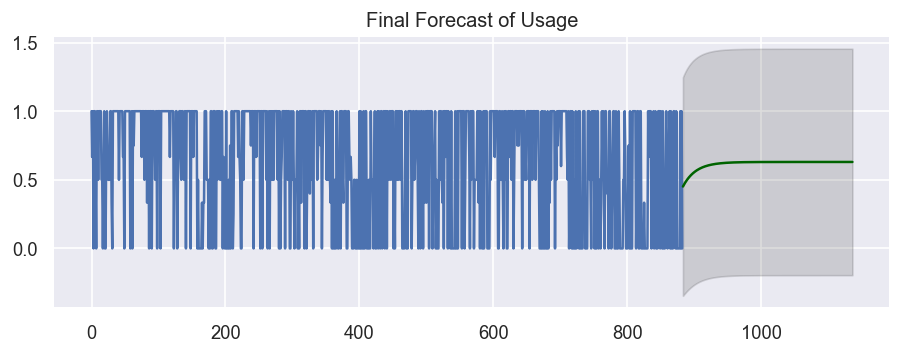

In [27]:
# Forecast
n_periods = 254
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.customer), len(df.customer)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.customer)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

# SARIMA model in python

In [20]:
raw_csv_data = pd.read_csv("Week11_in10mins.csv")      #import the csv
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp.customer =df_comp.customer.fillna(value = df_comp.customer.mean())

In [21]:
size = int(len(df_comp)*0.8)
train, test = df_comp.iloc[:size], df_comp.iloc[size:]
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df_comp.customer[:size]#'2021-05-31'
test = df_comp.customer[size:]

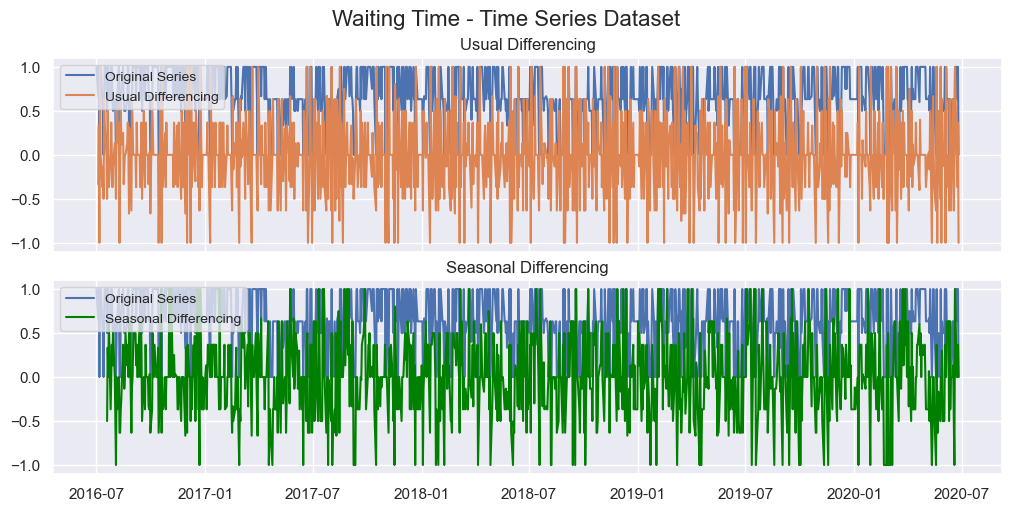

In [22]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True, constrained_layout=True)

# Usual Differencing
axes[0].plot(train[:], label='Original Series')
axes[0].plot(train[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(train[:], label='Original Series')
axes[1].plot(train[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Waiting Time - Time Series Dataset', fontsize=16)
plt.show()

In [23]:
import pmdarima as pm


In [24]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1332.294, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1084.421, Time=0.76 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1330.318, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1332.347, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=976.460, Time=1.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.28 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=978.099, Time=1.55 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=971.820, Time=3.32 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1078.331, Time=1.04 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.46 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.83 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=968.942, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1040
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -474.660
Date:                             Mon, 08 Nov 2021   AIC                            959.319
Time:                                     16:38:36   BIC                            983.996
Sample:                                          0   HQIC                           968.686
                                            - 1040                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8644      0.072     12.008      0.000       0.723       1.006
ma.L1         -0.7916      0.087     -9.085      0.000      -0.962      -0.621
ar.S.L12      -0.6360      0.031    -20.679      0.000      -0.696      -0.576
ar.S.L24      -0.3273      0.031    -10.570      0.000      -0.388      -0.267
sigma2         0.1466      0.007     21.448      0.000       0.133       0.160
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                29.34
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.40
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

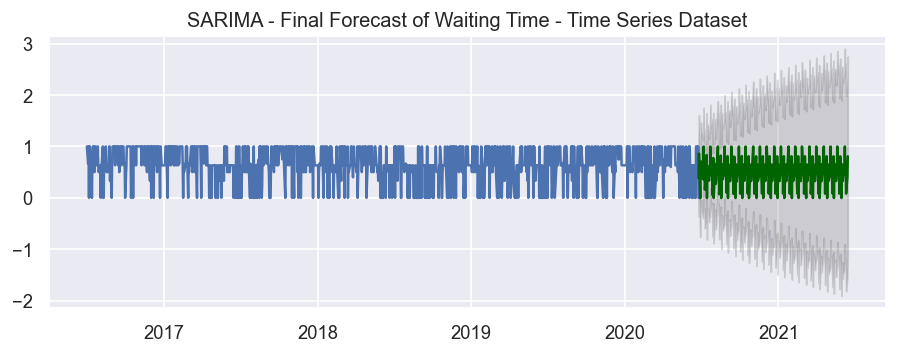

In [25]:
# Forecast
n_periods = 254
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='B')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Waiting Time - Time Series Dataset")
plt.show()

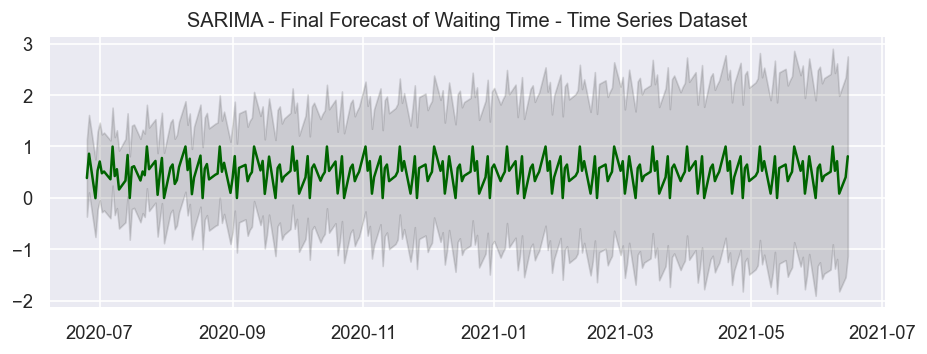

In [26]:
#zoom in version for SARIMA final 
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Waiting Time - Time Series Dataset")
plt.show()